# ADS-B Workflow

This notebook outlines an example workflow and quality assurance/quality control steps for working with ADS-B flight trajectories.

Specifically:
1) Fetching of data from the ADS-B telemetry endpoint
2) Overview of ADS-B data fields and anatomy
3) Extraction of individual flight instances
4) Validation & QA/QC of flight instances

>  **_NOTE_** A *flight instance* refers to a the collection of waypoints representing a single flight trajectory (an instance of takeoff to landing). 

## Prerequisites

Familiarize yourself with the [Contrails API ADS-B Telemetry endpoint](https://apidocs.contrails.org/notebooks/adsb_api.html).

## Step 1a: Fetch two days of global ADS-B data (METHOD 1 - synchronous)

The following approach iteratively (synchronously) fetches 1 hour chunks of global ADS-B data from the API, and saves those data to parquet files on local disk.

This approach takes longer to run, but is easier to debug and less prone to memory or Python async management issues.

In [ ]:
import os

import pandas as pd  # pip install pandas
import requests  # pip install requests

URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

times = pd.date_range("2025-02-01T00", "2025-02-02T23", freq="1h", inclusive="both", tz="UTC")

# iterate over datetime_range and fetch ADS-B data, saving it to local disk
destination_dir = "adsb_method1"
os.makedirs(destination_dir, exist_ok=True)

for time in times:
    params = {"date": time.strftime("%Y-%m-%dT%H")}

    r = requests.get(f"{URL}/v1/adsb/telemetry", params=params, headers=HEADERS, timeout=120)
    r.raise_for_status()

    # write out response content as parquet file
    with open(f"{destination_dir}/{params['date']}.pq", "wb") as f:
        f.write(r.content)

## Step 1b: Fetch two days of global ADS-B data (METHOD 2 - asynchronous)
The following approach concurrently (asynchronously) fetches 1 hour chunks of global ADS-B data from the API, and saves those data to parquet files on local disk.

This approach has a faster runtime, but requires an understanding of memory management & Python asynchronous methods.

In [ ]:
import asyncio
import os

import httpx  # pip install httpx
import pandas as pd  # pip install pandas

URL = "https://api.contrails.org"
API_KEY = os.environ["CONTRAILS_API_KEY"]
HEADERS = {"x-api-key": API_KEY}

times = pd.date_range("2025-02-01T00", "2025-02-02T23", freq="1h", inclusive="both", tz="UTC")

# iterate over datetime_range and fetch ADS-B data, saving it to local disk
destination_dir = "adsb_method2"
os.makedirs(destination_dir, exist_ok=True)


async def fetch_target_hour(
    semaphore: asyncio.locks.Semaphore, time: pd.Timestamp, destination_directory: str
) -> None:
    """Call the telemetry endpoint for a single time, and save the parquet file to disk."""

    params = {"date": time.strftime("%Y-%m-%dT%H")}
    async with semaphore, httpx.AsyncClient() as client:
        r = await client.get(
            f"{URL}/v1/adsb/telemetry",
            params=params,
            headers=HEADERS,
            timeout=120,
        )
        r.raise_for_status()

        # write out response content as parquet file
        with open(f"{destination_directory}/{params['date']}.pq", "wb") as f:
            f.write(r.content)


async def run_routines(semaphore: asyncio.locks.Semaphore):
    """Run the fetch_target_hour() function for each time in the times list."""
    routines = [fetch_target_hour(semaphore, time, destination_dir) for time in times]
    await asyncio.gather(*routines)


# limit the number of concurrent tasks running at any given time
max_concurrent_tasks = 6
sem_lock = asyncio.Semaphore(max_concurrent_tasks)
await run_routines(sem_lock)

## Step 2 - load data

Load the parquet files (fetched from Step 1) into a pandas dataframe.


In [1]:
import pandas as pd

destination_dir = "adsb_method2"

df = pd.read_parquet(destination_dir)  # load all pq files present in the directory
df

timestamp   latitude   longitude collection_type  \
0        2025-02-01 00:59:59  25.676445   54.505299     terrestrial   
1        2025-02-01 00:59:59  29.590485   32.469460     terrestrial   
2        2025-02-01 00:59:59  35.852440 -119.786217     terrestrial   
3        2025-02-01 00:59:59  41.100597  -78.485016     terrestrial   
4        2025-02-01 00:59:59   8.320747  -79.484901     terrestrial   
...                      ...        ...         ...             ...   
52280762 2025-02-02 23:00:00  35.741821  -79.977608     terrestrial   
52280763 2025-02-02 23:00:00  32.650223  -95.647522     terrestrial   
52280764 2025-02-02 23:00:00  33.047882  -96.192169     terrestrial   
52280765 2025-02-02 23:00:00  40.460953 -111.951111     terrestrial   
52280766 2025-02-02 23:00:00  29.902313  -94.515434     terrestrial   

          altitude_baro  altitude_gnss icao_address  \
0                 36975            NaN       0101DE   
1                 28000            NaN       0100DB   
2                 36000            NaN       0D07A8   
3                 37000            NaN       0C6061   
4                 11175            NaN       0C21A3   
...                 ...            ...          ...   
52280762          27175            NaN       A8AE7F   
52280763          23000            NaN       AA01DE   
52280764          19925            NaN       A7E9E7   
52280765          14125            NaN       A32C1E   
52280766          17525            NaN       A0FE7A   

                                     flight_id callsign tail_number  \
0         09fbb48d-6678-4bc8-9af2-f9cc39f5a92a   MSR951      SU-GEU   
1         deb06dee-361d-4f55-8240-825c0dcec2fa   MSR931      SU-GCM   
2         5c0a0363-e3e5-4ceb-8ded-49be4daac430  VOI7712      XA-VOY   
3         dbd65885-f2a4-469e-b82a-c8acace589de   BWA600      9Y-TTO   
4         1a0404bc-26cf-409d-ab3f-e1456391e828   CMP132  HP-9801CMP   
...                                        ...      ...         ...   
52280762  0e33f482-7857-44ec-8f07-d7cd552e0be6  DAL2855      N659DL   
52280763  309893aa-4117-4898-848e-cab88a433703  SKW6486      N744EV   
52280764  682f72f7-4258-43f8-ac5c-a43f9b0555d1  JIA5605      N609NN   
52280765  c0098d49-b0c8-46d4-9042-2e3041f013fb  SKW3737      N303SY   
52280766  8cb8df5d-26ea-41d4-82e0-cc5d2376e9f6  SKW5356      N163SY   

         flight_number aircraft_type_icao airline_iata departure_airport_icao  \
0                MS951               B789           MS                   HECA   
1                MS931               B738           MS                   OOMS   
2               Y47712               A320           Y4                   MMLO   
3                BW600               B38M           BW                   TTPP   
4                CM132               B38M           CM                   SPJC   
...                ...                ...          ...                    ...   
52280762        DL2855               B752           DL                   KRDU   
52280763        AA6486               CRJ7           OO                   KDFW   
52280764        AA5605               CRJ9           OH                   KDFW   
52280765        DL3737               E75L           OO                   KSLC   
52280766        UA5356               E75L           OO                   KIAH   

         departure_scheduled_time arrival_airport_icao arrival_scheduled_time  
0             2025-01-31 22:20:00                 ZSPD    2025-02-01 08:50:00  
1             2025-01-31 20:10:00                 HECA    2025-02-01 00:40:00  
2             2025-01-31 21:38:00                 KOAK    2025-02-01 01:56:00  
3             2025-01-31 19:55:00                 CYYZ    2025-02-01 02:00:00  
4             2025-01-31 21:40:00                 MPTO    2025-02-01 01:20:00  
...                           ...                  ...                    ...  
52280762      2025-02-02 22:35:00                 KATL    2025-02-03 00:12:00  
52280763      2025-02-02 22:35:00      

### Discussion - Anatomy of an ADS-B waypoint

The data surfaced in the ADS-B telemetry endpoint returns approximately 2 waypoints on a per-minute basis, for a given aircraft.  This is a best-effort approach to provide observations at the top and bottom of a given minute's interval.

Each ADS-B waypoint contains the following fields:

```text
timestamp
latitude
longitude
collection_type
altitude_baro
icao_address
flight_id
callsign
tail_number
flight_number
aircraft_type_icao
airline_iata
departure_airport_icao
departure_scheduled_time
airport_arrival_icao
arrival_scheduled_time
```

> BEWARE: in principle, all fields _except_ latitude, longitude, altitude and timestamp (space/time) _should_ be invariant on a per flight instance (flight_id) basis. As we will see in the data handling and QAQC section, this is often not the case... For instance, it is common to see the callsign of a flight change several minutes into the beginning of a new flight instance, etc.


#### Timestamp
This is the timestamp, in second precision, for the reported aircraft position. Timezone is UTC.

#### latitude & longitude
X,Y positional data of the aircraft at the reported timestamp.

#### collection_type
An indicator of whether these data were collected from terrestrial or sattelite receivers.  Possible values for this field include `terrestrial` and `satellite`.  Notably, records with `collection_type` of `satellite` do not have a `flight_id` (i.e. `null` value), as Spire is unable to assign a `flight_id` to these records.  The data handling section further down discusses how to impute `flight_id`s for records that are missing them.

Please note that, starting Dec 2024, Spire is not providing any records with `collection_type` of `satellite`, as their satellite constelation was decomissioned earlier than expected given unusually high solar wear'n'tear.  They do plan to gradually reimplement satellite data coverage, but volume and exact dates for those data is not clear.

#### altitude_baro
Barometric altitude of the aircraft, in feet above MSL, at the reported timestamp. Barometric altitude is imputed from the pressure measured by an aircraft's static port and is equal to geometric altitude only under specific atmospheric conditions.

#### altitude_gnss
Geometric altitude of the aircraft, derived from GNSS satellite data, at the reported timestamp. Geometric altitude is not reported by all flights, and missing values are filled with `NaN`.

#### icao_address
The icao identifier of the aircraft. This is unique to the aircraft, and, for commercial jets, is typically the identifier of the aircraft's S-type transponder.  This is considered to be the most robust unique identifier for grouping all data belonging to a specific aircraft.

#### flight_id
The UUID generated by Spire as a best-effort to uniquely identify a flight instance.  All waypoints grouped on a `flight_id` _should_ represent the trajectory of a single flight instance. It does happen, from time to time, that the `flight_id` is erroneous. This is addressed in the data QA/QC section further down.  As mentioned above, the `flight_id` is generally non-null, except for waypoints that are satellite observations.

#### callsign
The reported call sign for the aircraft on for given flight instance.

#### tail_number 
The reported tail number of the aircraft.

#### flight_number
The reported flight number of the aircraft for a given flight instance.

#### aircraft_type_icao
The type of aircraft (ICAO designator).

#### airline_iata
The airline IATA designator, for flights belonging to a registered airline (this is `null` for general aviation).

#### departure_airport_icao & arrival_airport_icao
The departure or arrival airport (ICAO designator) for a given flight instance.

#### departure_scheduled_time & arrival_scheduled_time
The departure or arrival scheduled time for a given flight instance. Timezone is UTC.


# Step 3 - Data Workflow

The following workflow demonstrates some common data manipulations applied to these data.

## Step 3a - Filtering

Let's filter our data to make subsequent data mongering more manageable, effectively minifying our dataset to only those data of interest for our hypothetical workflow.

Suppose our workflow only concerns itself with flights from American Airlines (airline_iata: `AA`) flights.

In [2]:
filt = df["airline_iata"] == "AA"

# apply filter and only retain American Airlines waypoints
df = df[filt]

## Step 3b - Flight ID imputation

Next, we'll impute any missing `flight_id` values.  As noted above, this is typically encountered for records with `collection_type` of `satellite` where Spire is unable to provide a `flight_id` match.

The imputation logic applies a simple heuristic.
First, we sort by `icao_address` (first) and `timestamp` (second).
This gives us the temporally continuous lineage of positions for each aircraft (takeoff, flight, landing, takeoff, flight, landing, etc...).
We then simply forward-fill `flight_id` for any missing data.  This assumes that a given flight instance will always have a non-null `flight_id` at the beginning of the flight, which is a good assumption, given that terrestrial ADS-B observations are almost always available for an aircraft taking off from an airport.


In [3]:
df = df.sort_values(["icao_address", "timestamp"], ascending=True)
df["flight_id"] = df["flight_id"].ffill()

## Step 3c - Janitorial work

Also, let's perform some janitorial work & remove any fragmented flight instances. Because we pulled an arbitrary time range of data, we expect that there are fragmented flights on the head and tailend of our dataset (flights that began before our time window start, or, flights that started but didn't end before our time window end).

In [4]:
# to identify flight fragments, we will find instances where the first or last waypoint in a flight have an altitude above a threshold
# any waypoints with those flagged flight_ids will be removed from the dataset

# min altitude for takeoff or landing
# highest airport in world is ~14.5k ft
alt_threshold_ft = 15_000

df = df.sort_values(["flight_id", "timestamp"], ascending=True)

In [5]:
def flight_start_end_above_alt(df: pd.DataFrame) -> bool:
    """Check if the first or last waypoint in a flight is above a threshold.

    Assumes dataframe is temporally sorted.
    """
    start_above_thres = df["altitude_baro"].iloc[0] > alt_threshold_ft
    end_above_thres = df["altitude_baro"].iloc[-1] > alt_threshold_ft
    return start_above_thres or end_above_thres


pre_filter_n_waypoints = len(df)
df = df.groupby("flight_id").filter(lambda x: not flight_start_end_above_alt(x))
post_filter_n_waypoints = len(df)
print(f"Dropped {pre_filter_n_waypoints - post_filter_n_waypoints} waypoints")

Dropped 160524 waypoints


### Step 3d - Flight Instance Manipulation (Resample, Heal, Validate)

As noted in the `Discussion - Anatomy of an ADS-B waypoint` section, waypoints belonging to a `flight_id` _should_ represent a well-formed flight instance.  Some flight instances, however, may violate one or more rules representing a well-formed flight instance.

The validation handler in Pycontrails is a utility that encapsulates a ruleset for evaluating a flight instance.
The validation handler consumes a single flight instance, and, if a violation occurs, will return one or more Exceptions representing the nature of the violation(s).

**SchemaError**

The flight instance has waypoints with malformed or missing fields.
See the `SCHEMA` class variable of the `ValidateTrajectoryHandler` ([Reference](https://github.com/contrailcirrus/pycontrails/blob/ecd01c1fc5834da716acb7839c6c8ca7c19ce0c8/pycontrails/datalib/spire/spire.py#L89))

**OrderingError**


The flight instance dataframe is not ordered/sorted correctly (descending timestamps).

**FlightDuplicateTimestamps**

The flight instance dataframe has one or more rows with duplicate timestamps.

**FlightInvariantFieldViolation**

The flight instance has one or more fields (columns) whose values are not invariant.
A valid trajectory assumes that the values for the following fields do not vary for a given flight instance ([Reference](https://github.com/contrailcirrus/pycontrails/blob/ecd01c1fc5834da716acb7839c6c8ca7c19ce0c8/pycontrails/datalib/spire/spire.py#L311)):
```text
[
 "icao_address",
 "flight_id",
 "callsign",
 "tail_number",
 "aircraft_type_icao",
 "airline_iata",
 "departure_airport_icao",
 "departure_scheduled_time",
 "arrival_airport_icao",
 "arrival_scheduled_time",
]
```

**OriginAirportError**

The flight instance's first waypoint is too far from the origin airport's location.

**DestinationAirportError**

The flight instance's first waypoint is too far from the origin airport's location.

**FlightTooShortError**

The flight instance is too short (in time duration).

**FlightTooLongError**

The flight instance is too long (in time duration).

**FlightTooSlowError**

The flight instance has periods where the speed is too slow.  This can either be instantaneous speed (speed imputed between consecutive waypoints) or the rolling average speed (the rolling avg speed threshold and windows width is defined in the handler's class vars).

**FlightTooLongError**

Same as `FlightTooSlowError` accept with upper speed thresholds.

**ROCDError**

The rate of climb or rate of descent of the aircraft (calculated between consecutive waypoints) is above a threshold.

**FlightAltitudeProfileError**

The flight instance drops below an altitude (floor) during the flight.



#### Cleanup/Heal Trajectories
Before we scan the trajectories with the ValidateTrajectoryHandler, we'll first apply some common cleanup/fixes to flight trajectories.

**The heuristics applied here will eventually be encapsulated in a Handler available via the pycontrails package**


In [6]:
def key_max_value_count(df, column_name):
    """If multiple unique values exist in a column, return the value with the highest count.

    Note that null values are not considered in the stack rank.
    """
    counts = df[column_name].value_counts()
    return counts.index[0] if not counts.empty else None


def get_priority_map(df: pd.DataFrame, cols: list) -> dict:
    """Return a mapping of the column name to the value of highest count in the column.

    Parameters
    ----------
    df
        A pandas dataframe
    cols
        Names of columns for evaluation. e.g. col=["callsign", "airline_iata"]

    Returns
    -------
    A dict with mapping of cols to value of highest count
    e.g. ``{"callsign": None, "airline_iata": AA}``
    """

    ret = {}
    for col in cols:
        prio_val = key_max_value_count(df, col)
        ret[col] = prio_val
    return ret


def dataframe_convert_types(df: pd.DataFrame) -> pd.DataFrame:
    """Attempt to convert types for each dataframe column to expected type.

    Implicitly also checks for existence of expected columns.
    """
    cols = {
        "icao_address": str,
        "flight_id": str,
        "callsign": str,
        "tail_number": str,
        "flight_number": str,
        "aircraft_type_icao": str,
        "airline_iata": str,
        "departure_airport_icao": str,
        "departure_scheduled_time": "datetime64[ns]",
        "arrival_airport_icao": str,
        "arrival_scheduled_time": "datetime64[ns]",
        "timestamp": "datetime64[ns]",
        "latitude": float,
        "longitude": float,
        "collection_type": str,
        "altitude_baro": int,
    }
    df = df.astype(cols)
    df["ingestion_time"] = pd.NaT
    return df


def drop_duplicate_ts(df: pd.DataFrame) -> pd.DataFrame:
    """Drop rows with duplicate timestamp fields."""
    return df.drop_duplicates(subset="timestamp", keep="first")


def heal(df: pd.DataFrame) -> pd.DataFrame:
    """
    Manipulate trajectories with qaqc heuristics.

    Returns
    -------
    Dataset mirroring initiated dataset, with manipulations applied.
    """

    try:
        df = dataframe_convert_types(df)
    except KeyError as e:
        raise KeyError("flight trajectory dataframe is missing an expected column.") from e

    df = df.replace("nan", None)

    # drop dupes
    df = drop_duplicate_ts(df)

    # --------------
    # update dataset so the following target keys are uniform/distinct for a given flight
    # --------------
    target_cols = [
        "callsign",
        "flight_number",
        "arrival_airport_icao",
        "departure_airport_icao",
        "airline_iata",
    ]

    priority_values = get_priority_map(df, target_cols)

    # fill any null values with our priority values
    for col, val in priority_values.items():
        if val:
            df[col] = df[col].fillna(val)

    # drop any rows where our column values don't match the priority value
    for col, val in priority_values.items():
        if val:
            keep_filter = df[col] == val
            df = df[keep_filter]

    df = df.sort_values(by="timestamp", ascending=True).reset_index(drop=True)
    if df.empty:
        raise ValueError("flight trajectory is empty.")
    return df


# scan all our flight instances and apply the "heal" heuristics
# let's grab the first 100 flights from American Airlines to work with in the rest of the notebook
flight_instance_grps = df.groupby("flight_id")
healed_flights: list[pd.DataFrame] = []
for _, flight_df in flight_instance_grps:
    airline_iata = flight_df["airline_iata"]
    if airline_iata.iloc[0] == "AA":
        healed_flights.append(heal(flight_df))
    if len(healed_flights) == 100:
        break

#### Resample flight trajectories
The folowing workflow demonstrates how to use the pycontrails `resample_and_fill` method to resample a flight trajectory to a 1minute interval of flight segments.  This method also applies some cleanup and manipulation heuristics (for example, climb/descents aren't linearly interpolated between waypoints, rather a ramp function is applied, etc...).

Ref: https://github.com/contrailcirrus/pycontrails/blob/da099eed6e65eca4d3a04a809fb33845ea83e646/pycontrails/core/flight.py#L801

Note that there is some busy-work to marshal the flight dataframe into and out of a pycontrails Flight object.


In [7]:
import warnings

from pycontrails import Flight

warnings.filterwarnings("ignore")

healed_resampled_flights: list[pd.DataFrame] = []
for flight_df in healed_flights:
    df_tmp = flight_df.rename(columns={"altitude_baro": "altitude_ft", "timestamp": "time"})
    df_resampled = Flight(df_tmp).resample_and_fill().dataframe
    if df_resampled.empty:
        continue

    # Recompute the altitude_ft (pycontrails Flight.resample_and_fill returns altitude [m])
    df_resampled["altitude_baro"] = df_resampled.pop("altitude").multiply(3.28).astype(int)
    df_resampled = df_resampled.rename(columns={"time": "timestamp"})

    # resample_and_fill drops all of our metadata columns (everything accept lat, lon, time, altitude)
    # so we need to patch that back in
    # note that our healing process in the previous step guarantees that all of those metadata fields are invariant in value
    # thus we're safe to grab any row's value from the input df and patch into the output df

    # collection_type and ingestion_time are exceptions. There is no handling of those fields when interpolating between records
    # here, we just mask the value with null, to preserve schema

    col_patches = [
        "icao_address",
        "flight_id",
        "callsign",
        "tail_number",
        "flight_number",
        "aircraft_type_icao",
        "airline_iata",
        "departure_airport_icao",
        "departure_scheduled_time",
        "arrival_airport_icao",
        "arrival_scheduled_time",
        "collection_type",
    ]
    for col in col_patches:
        df_resampled[col] = flight_df[col].iloc[0]

    df_resampled["ingestion_time"] = pd.NaT
    df_resampled["collection_type"] = None

    df_resampled = df_resampled.sort_values("timestamp", ascending=True)
    healed_resampled_flights.append(df_resampled)

healed_resampled_flights[0]

longitude   latitude           timestamp  altitude_baro icao_address  \
0  -107.055359  39.577457 2025-02-02 00:10:00          13971       AC7581   
1  -107.109846  39.625671 2025-02-02 00:11:00          17280       AC7581   
2  -107.094761  39.698813 2025-02-02 00:12:00          19884       AC7581   
3  -106.996112  39.767361 2025-02-02 00:13:00          21257       AC7581   
4  -106.856049  39.822471 2025-02-02 00:14:00          22874       AC7581   
..         ...        ...                 ...            ...          ...   
90  -97.067077  32.896418 2025-02-02 01:40:00            774       AC7581   
91  -97.063822  32.894102 2025-02-02 01:41:00            774       AC7581   
92  -97.060568  32.891786 2025-02-02 01:42:00            774       AC7581   
93  -97.057313  32.889470 2025-02-02 01:43:00            774       AC7581   
94  -97.054059  32.887154 2025-02-02 01:44:00            774       AC7581   

                               flight_id callsign tail_number flight_number  \
0   0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
1   0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
2   0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
3   0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
4   0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
..                                   ...      ...         ...           ...   
90  0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
91  0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
92  0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
93  0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   
94  0007726f-28fc-4add-ade5-fae5d07542bf  AAL2165       N9012        AA2165   

   aircraft_type_icao airline_iata departure_airport_icao  \
0                A319           AA                   KEGE   
1                A319           AA                   KEGE   
2                A319           AA                   KEGE   
3                A319           AA                   KEGE   
4                A319           AA                   KEGE   
..                ...          ...                    ...   
90               A319           AA                   KEGE   
91               A319           AA                   KEGE   
92               A319           AA                   KEGE   
93               A319           AA                   KEGE   
94               A319           AA                   KEGE   

   departure_scheduled_time arrival_airport_icao arrival_scheduled_time  \
0       2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
1       2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
2       2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
3       2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
4       2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
..                      ...                  ...                    ...   
90      2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
91      2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
92      2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
93      2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   
94      2025-02-02 00:02:00                 KDFW    2025-02-02 02:20:00   

   collection_type ingestion_time  
0             None            NaT  
1             None            NaT  
2             None            NaT  
3             None            NaT  
4             None            NaT  
..             ...            ...  
90            None            NaT  
91            None            NaT  
92            None            NaT  
93            None            NaT  
94            None            NaT  

[95 rows x 17 columns]

#### Run the ValidateTrajectoryHandler

⚠️ **Use version of pycontrails 0.54.8 or later**

The following workflow demonstrates how to run the validation handler against flight instances.

We iterate over all the flight instances (groups of waypoints on a per `flight_id` basis), and for each flight instance, we ask whether or not the flight validates any rules in the ValidateTrajectoryHandler ruleset.  We segregate flight instances that have no violations, and we quarantine flight instances that violate one or more rules.

##### Monkeypatching Custom Thresholds
If you want to modify the thresholds used in the ruleset, you can monkey patch the class vars of the handler. See example below.

Ref: https://github.com/contrailcirrus/pycontrails/blob/da099eed6e65eca4d3a04a809fb33845ea83e646/pycontrails/datalib/spire/spire.py#L78


In [8]:
from pycontrails.datalib.spire import ValidateTrajectoryHandler

# iterate through our list of flight instance dataframes, and run the validation handler against each flight
# the validation handler will return a list of exception objects if a flight violates one or more rules
# (See the description of exceptions in Step 3c)

good_flights: list[pd.DataFrame] = []
bad_flights: list[tuple[pd.DataFrame, list[Exception]]] = []

vh = ValidateTrajectoryHandler()
vh.AIRPORT_DISTANCE_THRESHOLD_KM = 500.0  # relax threshold distance for origin/destination airports

for flight_df in healed_resampled_flights:
    vh.set(flight_df)
    violations = vh.evaluate()
    augmented_flight_df = vh.validation_df
    vh.unset()

    if violations:
        bad_flights.append((augmented_flight_df, violations))
    else:
        good_flights.append(flight_df)

print(
    f"Found {len(good_flights)} flights with no violations.\n"
    f"Found {len(bad_flights)} flights with one or more violations."
)

Found 90 flights with no violations.
Found 8 flights with one or more violations.


#####

#### Useful Helper: The "Validation Dataframe object"
Notice that in the above code block, we access the `validation_df` property of the ValidateTrajectoryHandler instance.
This is a dataframe that includes all of the input dataframe values AND additional columns for the imputed fields used in evaluating the flight.

These additional columns can be very helpful in assessing a flight instance that has one or more violations.  This `valudation_df` can also be a bonus/helpful utility for gaining access to these additional values, even for totally valid flight instances.

The additional values (columns) added to the `validation_df` property dataframe by the ValidateTrajectoryHandler include:
- elapsed_seconds (elapsed time between consecutive waypoints)
- elapsed_distance_m (elapsed distance between consecutive waypoints)
- ground_speed_m_s (speed between consecutive waypoints)
- rocd_fps (rate of climb/descent between consecutive waypoints)
- departure_airport_lon (longitude of the departure airport)
- departure_airport_lat (latitude of the departure airport)
- departure_airport_alt_ft (altitude of the departure airport)
- arrival_airport_lon (longitude of the arrival airport)
- arrival_airport_lat (latitude of the arrival airport)
- arrival_airport_alt_ft (altitude of the arrival airport)
- departure_airport_dist_m (distance from the current wayporiunt to the departure airport)
- arrival_airport_dist_m (distance from the current waypoint to the arrival airport)

#### Bad flights? What's next...

The ValidateTrajectoryHandler applies a strict and opinionated set of rules to a flight instance.  It is up to you, the implementer, to determine how you'd like to handle violations to the rules.

Some options include:
- monkey patching the handler with less strict thresholds (see example above where we relax the ROCD threshold)
- ignore certain violations, but honor others (this can be done by scanning and selectively handling the list of violations returned by the handler)
- selectively ignore certain violations, for instance, ignore a FlightTooFastError if there are fewer than 5 instances of the flight going too fast (this can be achieved by parsing the exception response message in a FlightTooFastError violation)
- selectivey heal certain violations, for instance, interpolate the first waypoint in a trajectory to the departure airport, for flights with an OriginAirportError violation.

#### Bad flight -- case study
From above, we see that our second flight w/ `flight_id` of `01fe97aa-173c-4041-906e-f1e9193502dd` has a `FlightTooSlowError` with message of `"Found 4 instances where rolling average speed is below threshold of 100.0 m/s (rolling window of 30.0 minutes). max value: 99.56874690879854, min value: 83.59578017138627"`, indicating that at 4 points in the trajectory, the rolling average speed dropped below the validation handler's threshold. 

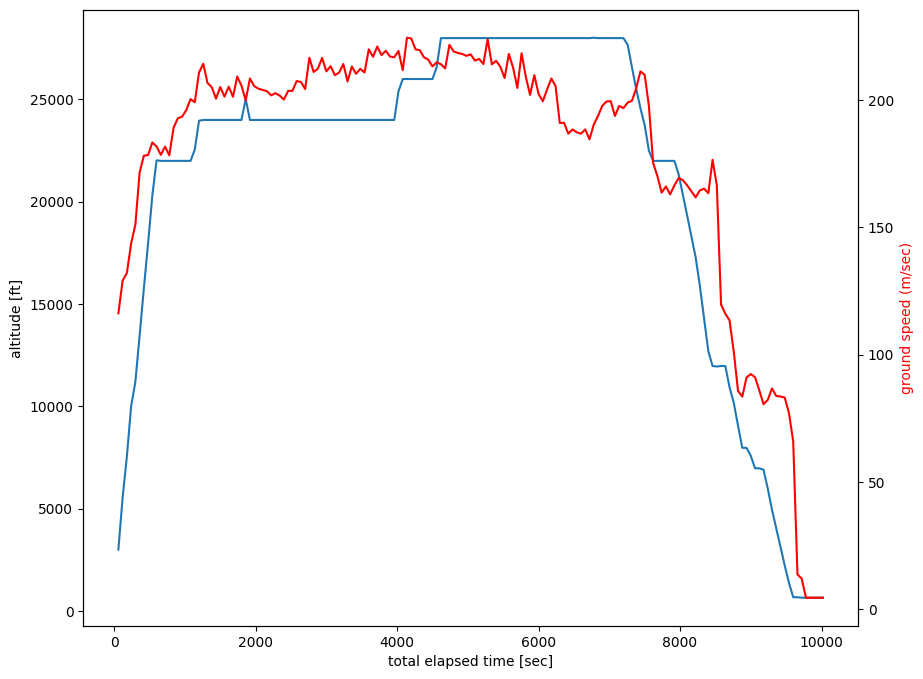

In [9]:
import matplotlib.pyplot as plt

df = bad_flights[2][0]
df.loc[:, "total_elapsed_sec"] = df["elapsed_seconds"].cumsum()
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
ax1.plot(df["total_elapsed_sec"], df["altitude_baro"])
ax1.set_ylabel("altitude [ft]")
ax1.set_xlabel("total elapsed time [sec]")

ax2 = ax1.twinx()
ax2.plot(df["total_elapsed_sec"], df["ground_speed_m_s"].abs(), color="r")
ax2.set_ylabel("ground speed (m/sec)", color="r")
plt.show()

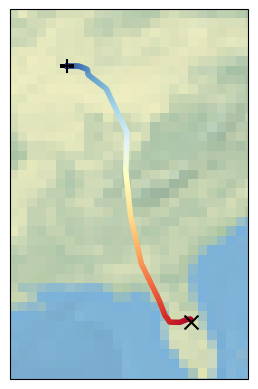

In [10]:
# plot flight trajectory -- visually inspect for anomalies
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
cm = plt.cm.get_cmap("RdYlBu")

plt.scatter(
    df["longitude"],
    df["latitude"],
    marker=".",
    c=df["total_elapsed_sec"],
    cmap=cm,
    transform=ccrs.Geodetic(),
)

plt.scatter(
    df["departure_airport_lon"].iloc[0],
    df["departure_airport_lat"].iloc[0],
    marker="x",
    color="black",
    s=100,
)
plt.scatter(
    df["arrival_airport_lon"].iloc[0],
    df["arrival_airport_lat"].iloc[0],
    marker="+",
    color="black",
    s=100,
)

ax.set_xlim([df["longitude"].min() - 3, df["longitude"].max() + 3])
ax.set_ylim([df["latitude"].min() - 3, df["latitude"].max() + 3])
plt.show()

## Discussion
An initial inspection of this flight suggests that it is a valid flight, and the low speed observed in the last ~ hour of flight time does not suggest an issue with the flight.  Decreasing the default `AVG_LOW_GROUND_SPEED_THRESHOLD_MPS`. Increasing the rolling average window width (`AVG_LOW_GROUND_SPEED_ROLLING_WINDOW_PERIOD_MIN`) may also smooth out and avoid triggering on shorter periods of low ground speed.

In general, this type of threshold parameter tuning should be caried out in the context of the application use case, and judgements based on acceptable false positive and false negative rates.